In [1]:
import numpy as np
import pandas as pd

import copy
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from dateutil.relativedelta import relativedelta

# Source: https://www.statsmodels.org/stable/install.html
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

# Source: https://scikit-learn.org/stable/install.html
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from dateutil.relativedelta import relativedelta

# Source: https://www.statsmodels.org/stable/install.html
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Source: https://scikit-learn.org/stable/install.html
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


In [2]:
df = pd.read_csv('data/Amazon_Historical_StockPrice2.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-03-28,584.400024,584.750000,575.559998,579.869995,579.869995,3121500
1,2016-03-29,580.150024,595.849976,576.500000,593.859985,593.859985,4392600
2,2016-03-30,596.710022,603.239990,595.000000,598.690002,598.690002,3890500
3,2016-03-31,599.280029,600.750000,592.210022,593.640015,593.640015,2681800
4,2016-04-01,590.489990,599.030029,588.299988,598.500000,598.500000,2917400


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1260 non-null   object 
 1   Open       1260 non-null   float64
 2   High       1260 non-null   float64
 3   Low        1260 non-null   float64
 4   Close      1260 non-null   float64
 5   Adj Close  1260 non-null   float64
 6   Volume     1260 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


In [4]:
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
from datetime import datetime
from pandas.tseries.offsets import DateOffset
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
df["Date"] = df["Date"].transform(lambda x: parse(x))

In [6]:
start_date = np.min(df["Date"])
last_date = np.max(df["Date"])
current_month = start_date - DateOffset(days=start_date.day - 1)
next_month = current_month + DateOffset(months = 1)
prices = []
months = []
while next_month < last_date:
    days = df[(df.Date >= current_month) & (df.Date < next_month)]
    prices.append(np.average(days["High"]))
    months.append(current_month)
    current_month = next_month
    next_month += DateOffset(months = 1)
df2 = pd.DataFrame(data={'date': months, 'prices' : prices})
df2 = df2.set_index(['date'])
df2.head()

,prices
date,
2016-03-01,596.147491
2016-04-01,619.647618
2016-05-01,702.979042
2016-06-01,721.051364
2016-07-01,746.521500


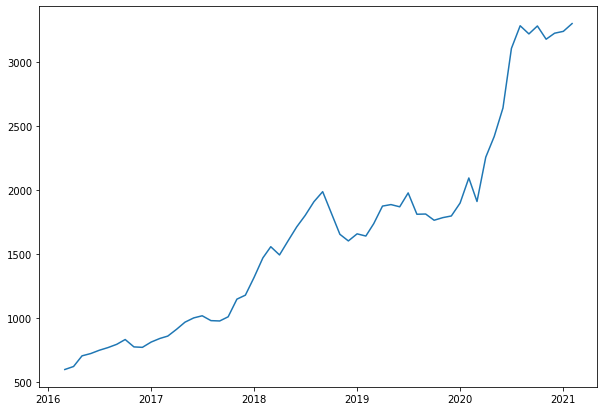

In [7]:
plt.figure(figsize=(10, 7))
plt.plot(months, prices)
plt.show()

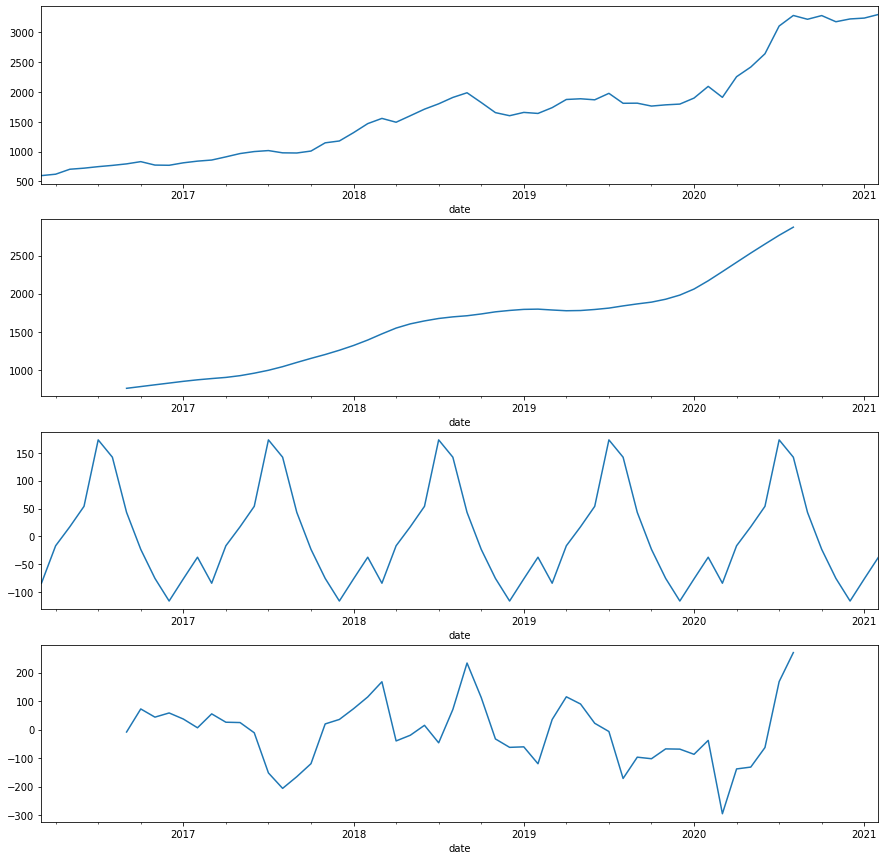

In [8]:
plt.figure(figsize=(15, 15))
decomposition = seasonal_decompose(pd.Series(df2.prices))

ax = plt.subplot(411)
decomposition.observed.plot(ax=ax)

ax = plt.subplot(412)
decomposition.trend.plot(ax=ax)

ax = plt.subplot(413)
decomposition.seasonal.plot(ax=ax)

ax = plt.subplot(414)
decomposition.resid.plot(ax=ax);

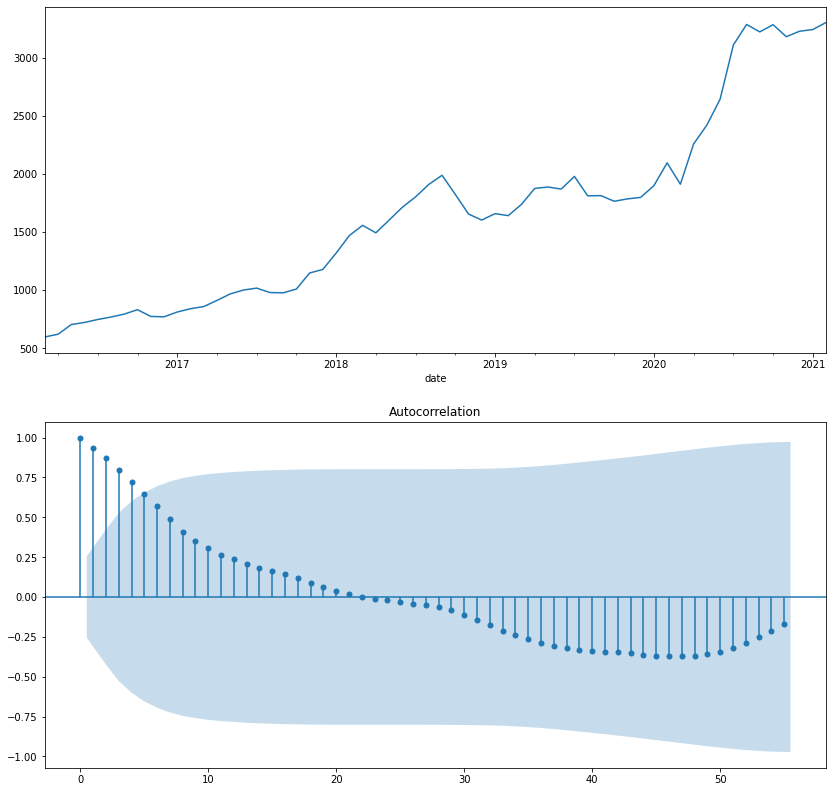

In [9]:
plt.figure(figsize=(14, 14))

ax = plt.subplot(211)
df2['prices'].plot(ax=ax)

ax = plt.subplot(212)
plot_acf(df2['prices'][1:], lags=55, ax=ax);

In [10]:
p_value = adfuller(df2['prices'])[1]

print(
    f'Полученный уровень значимости (p-value): {round(p_value, 4)}.',
    f'{round(p_value, 4)} > 0.05. Нулевая гипотеза не отвергается в пользу альтернативной!'
)

Полученный уровень значимости (p-value): 0.9766. 0.9766 > 0.05. Нулевая гипотеза не отвергается в пользу альтернативной!


Попробуем диффиринцировать

Полученный уровень значимости (p-value): 0.0. 0.0 < 0.05. Нулевая гипотеза отвергается в пользу альтернативной! Ряд может быть стационарным.


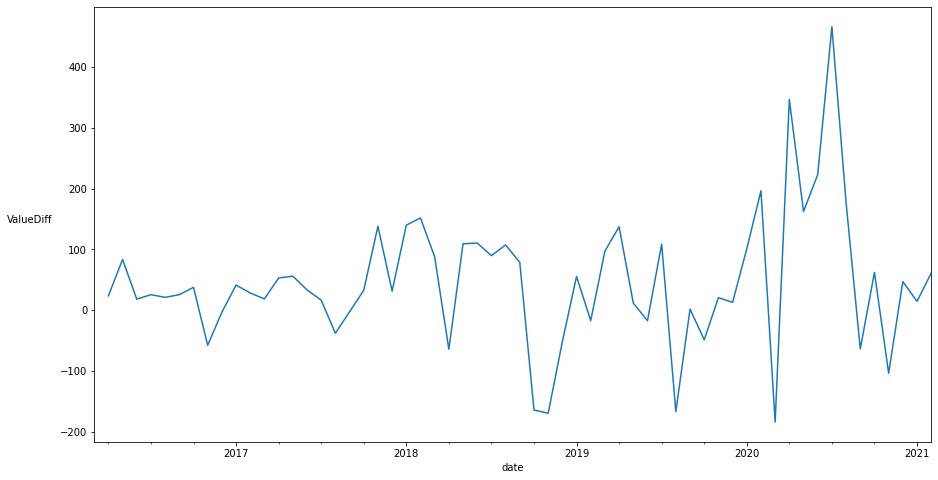

In [11]:
df2['ValueDiff'] = df2['prices'] - df2['prices'].shift(1)
p_value = adfuller(df2["ValueDiff"][1:])[1]

print(
    f'Полученный уровень значимости (p-value): {round(p_value, 4)}.',
    f'{round(p_value, 4)} < 0.05. Нулевая гипотеза отвергается в пользу альтернативной! Ряд может быть стационарным.'
)

plt.figure(figsize=(15, 8))
plt.ylabel("ValueDiff", rotation=0, labelpad=30)
df2["ValueDiff"].plot();

Хоть тест и и показал стационарность видем увеличенние диссперсии полсе 2020 года.

Попробуем логарифмировать.

Полученный уровень значимости (p-value): 0.7876. 0.7876 > 0.05. Нулевая гипотеза не отвергается в пользу альтернативной! Ряд не стационарный.


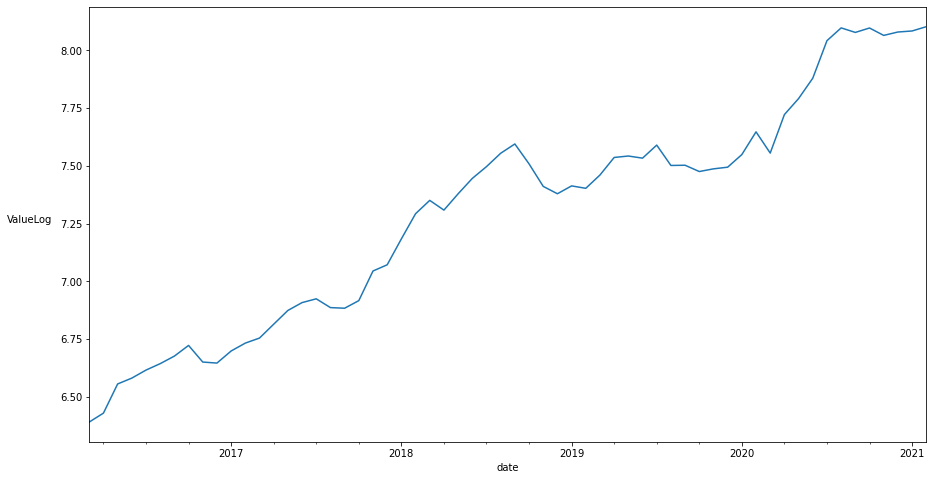

In [12]:
df2['ValueLog'] = np.log(df2['prices'])

p_value = adfuller(df2['ValueLog'])[1]

print(
    f'Полученный уровень значимости (p-value): {round(p_value, 4)}.',
    f'{round(p_value, 4)} > 0.05. Нулевая гипотеза не отвергается в пользу альтернативной! Ряд не стационарный.'
)

plt.figure(figsize=(15, 8))
plt.ylabel('ValueLog', rotation=0, labelpad=30)
df2['ValueLog'].plot();

Ряд не стационарный.

Попробуем диффиринцировать логарифмированный ряд.

Полученный уровень значимости (p-value): 0.0. 0.0 < 0.05. Нулевая гипотеза отвергается в пользу альтернативной! Ряд может быть стационарным.


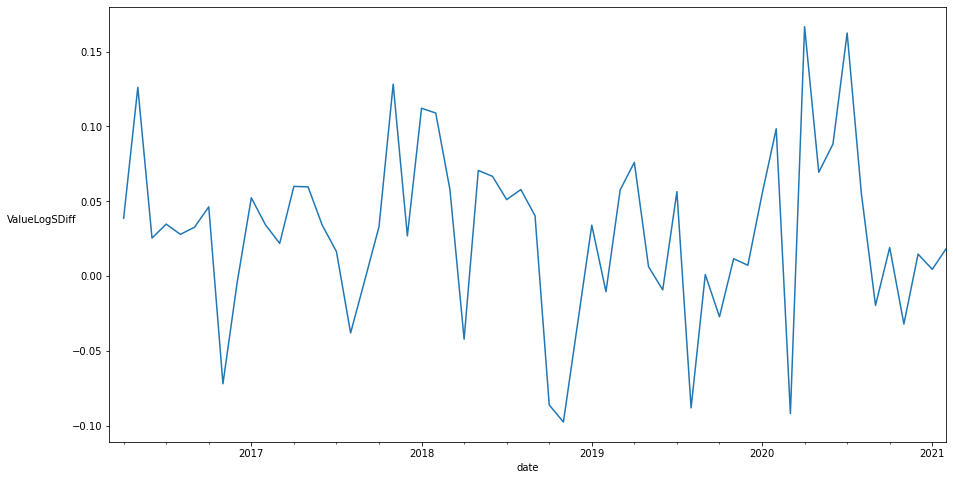

In [13]:
df2['ValueLogSDiff'] = df2['ValueLog'] - df2['ValueLog'].shift(1)
p_value = adfuller(df2["ValueLogSDiff"][1:])[1]

print(
    f'Полученный уровень значимости (p-value): {round(p_value, 4)}.',
    f'{round(p_value, 4)} < 0.05. Нулевая гипотеза отвергается в пользу альтернативной! Ряд может быть стационарным.'
)

plt.figure(figsize=(15, 8))
plt.ylabel('ValueLogSDiff', rotation=0, labelpad=30)
df2['ValueLogSDiff'].plot();

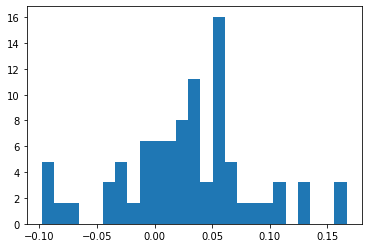

In [14]:
plt.hist(df2['ValueLogSDiff'], density=True, bins=25);

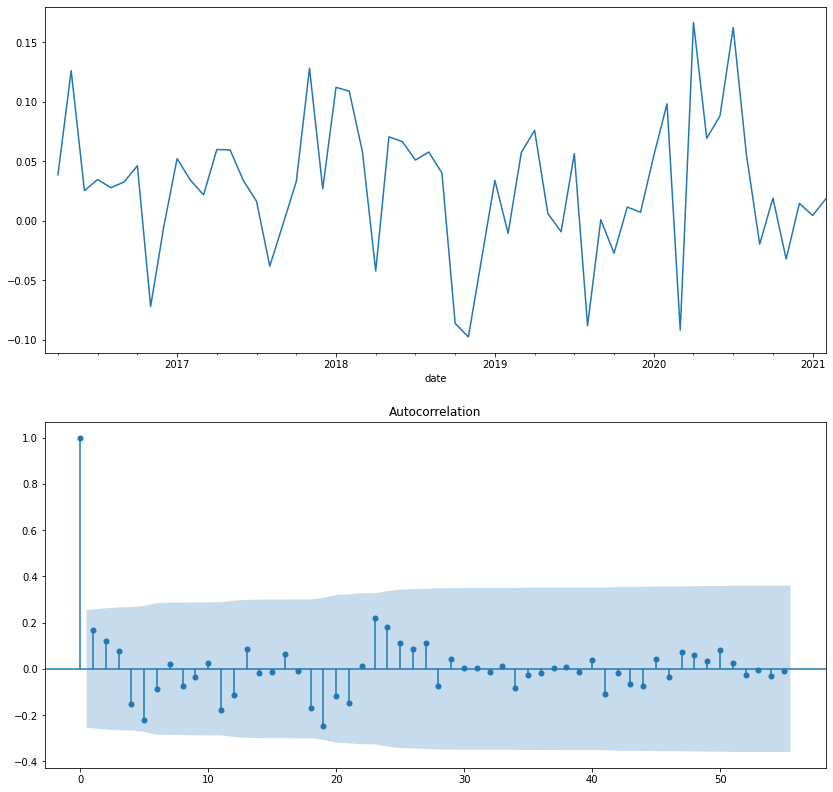

In [15]:
plt.figure(figsize=(14, 14))

ax = plt.subplot(211)
df2['ValueLogSDiff'].plot(ax=ax)

ax = plt.subplot(212)
plot_acf(df2['ValueLogSDiff'][1:], lags=55, ax=ax);

Ряд стационарный.

In [16]:
d=1
D=1

qs = range(1, 5)
Qs = range(1, 3)

ps = range(1, 5)
Ps = range(3, 5)

In [17]:
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

64

In [18]:
%%time
import statsmodels.api as sm

results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    try:
        model = sm.tsa.statespace.SARIMAX(
            df2['ValueLog'][:45], 
            order=(param[0], d, param[1]), 
            seasonal_order=(param[2], D, param[3], 12)
        ).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

  0%|                                                                                           | 0/64 [00:00<?, ?it/s]D:\Programs\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
D:\Programs\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
D:\Programs\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
  2%|█▎                                                                                 | 1/64 [00:00<00:53,  1.18it/s]D:\Programs\anaconda3\lib\site-pack

Wall time: 2min 51s


In [19]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
0   (1, 1, 3, 1) -76.105117
4   (1, 2, 3, 1) -74.252405
16  (2, 1, 3, 1) -74.117853
1   (1, 1, 3, 2) -74.106047
2   (1, 1, 4, 1) -74.105865


In [20]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           ValueLog   No. Observations:                   45
Model:             SARIMAX(1, 1, 1)x(3, 1, 1, 12)   Log Likelihood                  45.053
Date:                            Tue, 07 Dec 2021   AIC                            -76.105
Time:                                    18:29:50   BIC                            -65.845
Sample:                                03-01-2016   HQIC                           -72.704
                                     - 11-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1770      0.828     -0.214      0.831      -1.799       1.446
ma.L1          0.4510      0.696   

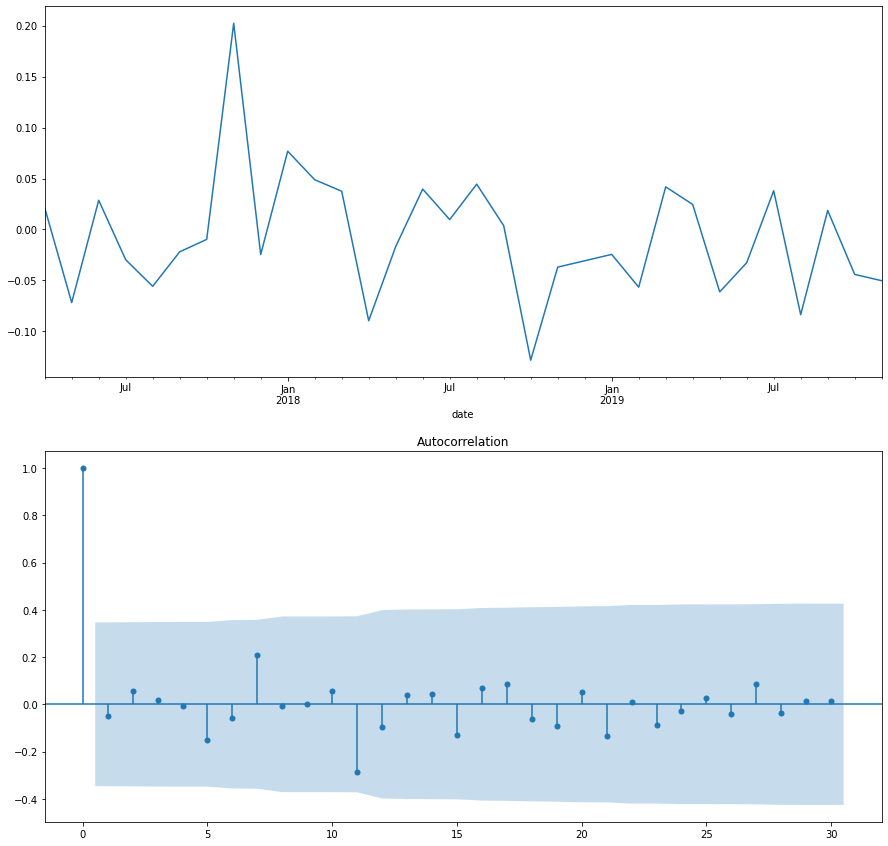

In [21]:
plt.figure(figsize=(15,15))

plt.subplot(211)
best_model.resid[13:].plot()

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=30, ax=ax);

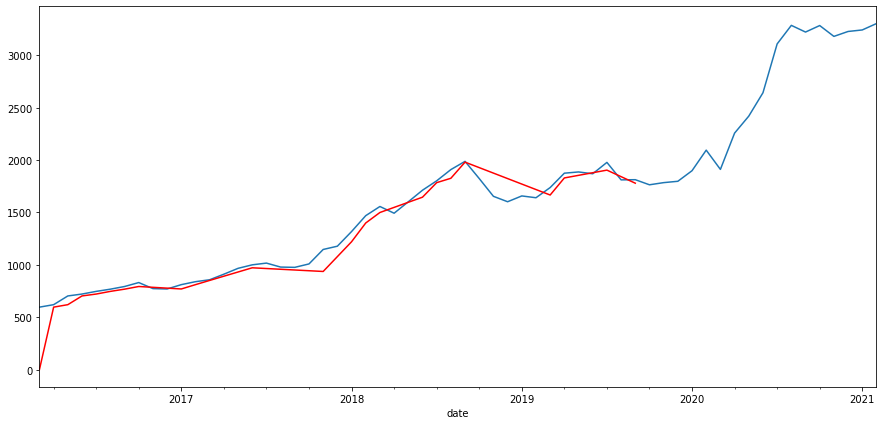

In [22]:
df2['Model'] = np.exp(best_model.fittedvalues)

df3 = df2[(df2.Model - df2.prices) < 10000 | (df2.Model == 0)]

plt.figure(figsize=(15,7))

df2['prices'].plot()
df3['Model'].plot(c='r');

In [23]:
print(df2.shape)
df3.tail()

(60, 5)


,prices,ValueDiff,ValueLog,ValueLogSDiff,Model
date,,,,,
2018-09-01,1987.199476,78.450787,7.594482,0.040278,1979.766744
2019-03-01,1737.247634,97.151828,7.460057,0.057547,1666.073392
2019-04-01,1874.405698,137.158064,7.536047,0.075990,1828.929441
2019-07-01,1977.383184,108.516198,7.589530,0.056442,1903.607751
2019-09-01,1812.319501,1.749493,7.502363,0.000966,1778.874950


In [24]:
new_close_value = df2[['prices', 'Model']]

new_close_value.tail()

,prices,Model
date,,
2020-10-01,3283.250888,NaN
2020-11-01,3179.721472,NaN
2020-12-01,3226.707242,NaN
2021-01-01,3241.233129,NaN
2021-02-01,3302.046836,NaN


<ipython-input-25-6c67e4e8f01c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_close_value['Model'] = np.exp(best_model.predict(start=45, end=65))


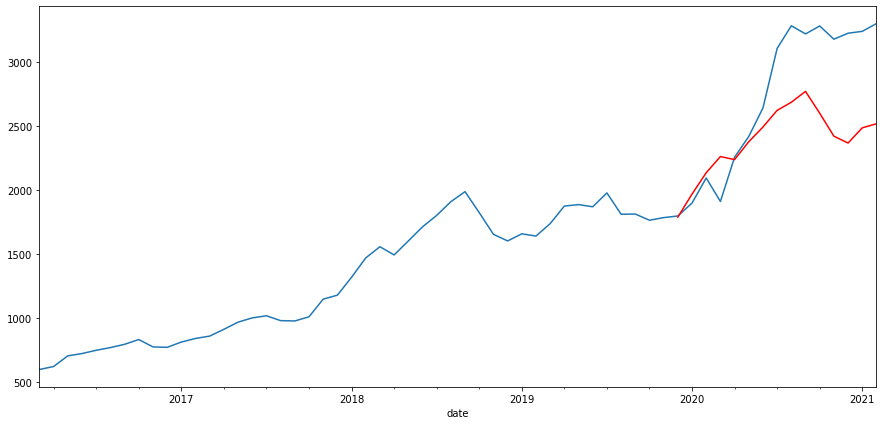

In [25]:
new_close_value['Model'] = np.exp(best_model.predict(start=45, end=65))

plt.figure(figsize=(15,7))
new_close_value['prices'].plot()
new_close_value['Model'].plot(c='r');

In [26]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(new_close_value['prices'][45:65], new_close_value['Model'][45:65])

0.13252276621939887